# Refer to peaked_circuit.ipynb for the main work. This notebook was built ontop of it to experiment with various algorithms

In [1]:
import pennylane as qml
import numpy as np
import bluequbit
import json
import os
from dotenv import load_dotenv
from collections import Counter


In [57]:
# all the libraries we are going to need
%pip install python-dotenv
%pip install bluequbit
%pip install circuit-knitting-toolbox
%pip install pennylane-qiskit
%pip install pylatexenc

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached pylatexenc-2.10-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
qasm_path = "circuit_qasm/P1_little_peak.qasm"
number_of_qubits = 4

# Load the circuit from QASM
with open(qasm_path, "r") as f:
    qasm_str = f.read()

# Create a device matching the number of qubits (adjust wires as needed)
dev = qml.device("default.qubit", wires=number_of_qubits,shots=1000)

# Convert QASM string to a PennyLane circuit
circuit = qml.from_qasm(qasm_str)

@qml.qnode(dev)
def run_circuit():
    circuit()
    return qml.probs()

# Run the circuit
state = run_circuit()
print(state)
print(qml.draw(circuit)())
max_index = np.argmax(state)
print(max_index)
print(format(max_index, f'0{number_of_qubits}b'))

[0.012 0.079 0.001 0.006 0.    0.005 0.    0.002 0.05  0.678 0.012 0.072
 0.006 0.072 0.001 0.004]
0: ──RY(2.51)───────────┤  
1: ──X─────────RY(2.51)─┤  
2: ──X─────────RY(2.51)─┤  
3: ──RY(2.51)───────────┤  
9
1001


In [36]:
import pennylane as qml
import numpy as np

# --- Config ---
qasm_path = "circuit_qasm/P1_little_peak.qasm"
n_system = 4
n_qpe = 4
wires_qpe = list(range(n_qpe))
wires_sys = list(range(n_qpe, n_qpe + n_system))

# Load the QASM circuit
with open(qasm_path, "r") as f:
    qasm_str = f.read()
state_prep = qml.from_qasm(qasm_str)

# Device
dev = qml.device("default.qubit", wires=n_qpe + n_system, shots=1000)

# Your diagonal unitary (can be replaced with any U)
def apply_U(wires):
    for w in wires:
        qml.PauliZ(wires=w)  # Simple Z, could be any unitary here

# Apply controlled-U^{2^k} for one QPE qubit
def apply_controlled_powers(control_wire, wires, power):
    for _ in range(power):
        qml.ctrl(apply_U, control=control_wire)(wires=wires)

@qml.qnode(dev)
def qpe_circuit():
    # Step 1: Prepare QPE register in superposition
    for w in wires_qpe:
        qml.Hadamard(w)

    # Step 2: Prepare the system state using your QASM
    state_prep(wires=wires_sys)

    # Step 3: Apply controlled-U^{2^k}
    for i, control_wire in enumerate(wires_qpe):
        power = 2 ** i
        apply_controlled_powers(control_wire, wires_sys, power)

    # Step 4: Apply inverse QFT to QPE register
    qml.adjoint(qml.templates.QFT)(wires=wires_qpe)

    # Step 5: Measure QPE register
    return qml.sample(wires=wires_qpe)

# Run the QPE circuit
samples = qpe_circuit()
print("Measured phase bitstrings:")
for sample in samples[:10]:
    print("".join(map(str, sample)))


Measured phase bitstrings:
0000
0000
0000
0001
0000
0000
0000
0000
0000
0000


# P2

In [3]:

load_dotenv() 

token = os.getenv("TOKEN")

In [4]:
# --- Config ---
qasm_path = "circuit_qasm/P2_swift_rise.qasm"
number_of_qubits = 28
shots = 1000
json_path = "resultsP2.json"

# --- Load QASM ---
with open(qasm_path, "r") as f:
    qasm_str = f.read()

# --- Setup Device and Circuit ---
dev = qml.device("bluequbit.cpu", wires=number_of_qubits, token=token, shots=shots)
circuit = qml.from_qasm(qasm_str)

@qml.qnode(dev)
def run_circuit():
    circuit()
    return qml.sample()

# --- Run the Circuit ---
state = run_circuit()
print(state)
print(qml.draw(circuit)())

# --- Convert Samples to Bitstrings ---
bitstrings = ["".join(map(str, s)) for s in state]  # Each sample to string
bitstring_counts = Counter(bitstrings)

# --- Update resultsP2.json ---
# Load old data if exists
if os.path.exists(json_path):
    with open(json_path, "r") as f:
        old_counts = json.load(f)
else:
    old_counts = {}

# Merge new counts
for k, v in bitstring_counts.items():
    old_counts[k] = old_counts.get(k, 0) + v

# Save updated results
with open(json_path, "w") as f:
    json.dump(old_counts, f, indent=4)

print("✅ All results saved and updated.")


[BQ-PYTHON-SDK][WARNING] - Beta version 0.12.0b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: BubKOJR39MWUiWHi, device: pennylane.cpu, run status: RUNNING, created on: 2025-04-13 09:49:55 UTC, estimated runtime: 116300 ms, estimated cost: $0.00, num qubits: 28
Job ID: BubKOJR39MWUiWHi, device: pennylane.cpu, run status: COMPLETED, created on: 2025-04-13 09:49:55 UTC, cost: $0.00, run time: 49703 ms, queue time: 164 ms, num qubits: 28
[[1 1 0 ... 1 0 0]
 [1 1 0 ... 1 0 0]
 [1 1 0 ... 1 0 0]
 ...
 [1 1 0 ... 1 0 0]
 [1 1 0 ... 1 0 0]
 [1 1 0 ... 1 0 0]]
 0: ──RZ(-0.48)──SX──RZ(-1.05)──SX──RZ(-2.62)─╭Z──RZ(-1.56)──SX──RZ(-1.49)──SX──RZ(2.69)─────╭●
 1: ──RZ(-0.93)──SX──RZ(-0.39)──SX──RZ(2.32)──╰●──RZ(-0.35)──SX──RZ(-2.86)──SX──RZ(-0.50)─╭Z─│─
 2: ──RZ(-1.50)──SX──RZ(-2.24)──SX──RZ(-1.20)─╭Z──RZ(1.67)───SX──RZ(-1.50)──SX──RZ(-2.07)─╰●─│─
 3: ──RZ(3.05)───SX──RZ(-0.79)──SX──RZ(1.08)──╰●──RZ(0.56)───SX──RZ(-1.34)──SX──RZ(-1.79)─╭Z─│─
 4: ──RZ(2.23)───SX──RZ(-1.81)──SX──RZ(-2.12)─╭Z──RZ(0.08)───SX──RZ(-0.98)──SX──RZ(0.49)──╰●─│─
 5: ──RZ(1.49

We created some function to help us save our shots so that we can decide to account for past result for better analysis. We don't want to run code that take forever to run multiple times for nothing. The following is just helper function to make it so each run, we get more and more measurements on the circuit we are studying.

In [5]:
json_path = "resultsP2.json"

# Load the JSON data
with open(json_path, "r") as f:
    result_counts = json.load(f)

# Total number of samples
total_counts = sum(result_counts.values())

# Sort by frequency (value), descending
sorted_results = sorted(result_counts.items(), key=lambda x: x[1], reverse=True)

# Display top 5 with probability
print("🔝 Top 5 most common bitstrings with probabilities:")
for bitstring, count in sorted_results[:5]:
    probability = count / total_counts
    print(f"{bitstring[::-1]} → {count} times ({probability:.4f} probability)")


🔝 Top 5 most common bitstrings with probabilities:
0011100001101100011011010011 → 1387 times (0.3459 probability)
0011011101101100011011010011 → 18 times (0.0045 probability)
0011100001101111110011010011 → 15 times (0.0037 probability)
0011100001101100011011101101 → 13 times (0.0032 probability)
0011100001110111111011010011 → 12 times (0.0030 probability)


In [39]:
import pennylane as qml
import numpy as np
from collections import Counter

# Load circuit and run once to identify the peak
qasm_path = "circuit_qasm/P1_little_peak.qasm"
n_system = 4
dev_temp = qml.device("default.qubit", wires=n_system, shots=1000)

with open(qasm_path, "r") as f:
    qasm_str = f.read()
state_prep = qml.from_qasm(qasm_str)

@qml.qnode(dev_temp)
def find_peak():
    state_prep(wires=range(n_system))
    return qml.sample()

samples = find_peak()
bitstrings = ["".join(map(str, s)) for s in samples]
peak_bitstring = Counter(bitstrings).most_common(1)[0][0]
print(f"🌟 Most frequent (peak) bitstring: {peak_bitstring}")


🌟 Most frequent (peak) bitstring: 1001


In [41]:
# Number of QPE qubits
n_qpe = 4
wires_qpe = list(range(n_qpe))
wires_sys = list(range(n_qpe, n_qpe + n_system))
all_wires = wires_qpe + wires_sys
dev = qml.device("default.qubit", wires=all_wires, shots=1000)

# Build oracle unitary as diagonal matrix
def build_oracle_matrix(peak_bitstring):
    dim = 2 ** n_system
    diag = np.ones(dim, dtype=complex)
    target_index = int(peak_bitstring, 2)
    diag[target_index] = -1
    return np.diag(diag)

oracle_matrix = build_oracle_matrix(peak_bitstring)

# Apply controlled-U^{2^k}
def apply_controlled_U(control, wires, power):
    U = np.linalg.matrix_power(oracle_matrix, power)
    qml.ControlledQubitUnitary(U, control_wires=control, wires=wires)

@qml.qnode(dev)
def qpe_amplify():
    # superposition
    for w in wires_qpe:
        qml.Hadamard(w)
    # QASM circuit 
    state_prep(wires=wires_sys)
    # Controlled-U^{2^k}
    for i, ctrl in enumerate(wires_qpe):
        power = 2 ** i
        apply_controlled_U(ctrl, wires_sys, power)
    # Step 4: Inverse QFT
    qml.adjoint(qml.templates.QFT)(wires=wires_qpe)
    # Step 5: Measure QPE register
    return qml.sample(wires=wires_qpe)

# Run
samples = qpe_amplify()
bitstring_samples = ["".join(map(str, s)) for s in samples]
count = Counter(bitstring_samples)
print("⏱️ QPE phase results (top 5):")
for b, c in count.most_common(5):
    print(f"{b} → {c} times")


⏱️ QPE phase results (top 5):
0000 → 327 times
0001 → 287 times
1111 → 265 times
0011 → 35 times
1101 → 27 times


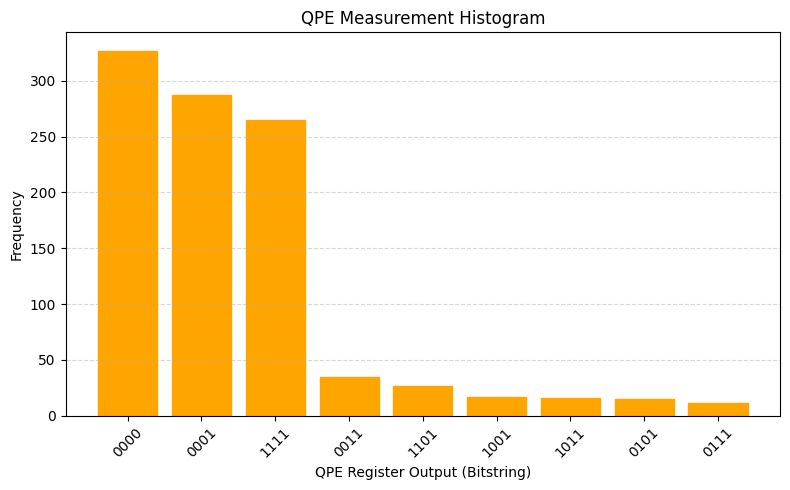

In [43]:
import matplotlib.pyplot as plt

# Your sample result (example data)
result_counts = count

# Sort by frequency or bitstring (optional)
sorted_items = sorted(result_counts.items(), key=lambda x: x[1], reverse=True)
bitstrings, counts = zip(*sorted_items)

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(bitstrings, counts)
plt.xlabel("QPE Register Output (Bitstring)")
plt.ylabel("Frequency")
plt.title("QPE Measurement Histogram")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Color bars (optional)
for bar in bars:
    bar.set_color("orange")

plt.tight_layout()
plt.show()


🌟 Identified peak bitstring: 1001

Results for k=0 iterations:
0000 → 13 times
0001 → 77 times
0011 → 4 times
0100 → 2 times
0101 → 4 times
1000 → 76 times
1001 → 664 times
1010 → 10 times
1011 → 61 times
1100 → 5 times
1101 → 77 times
1110 → 2 times
1111 → 5 times

Results for k=1 iterations:
0000 → 23 times
0001 → 191 times
0011 → 19 times
0100 → 3 times
0101 → 17 times
0111 → 1 times
1000 → 216 times
1001 → 75 times
1010 → 22 times
1011 → 200 times
1100 → 13 times
1101 → 198 times
1110 → 1 times
1111 → 21 times

Results for k=2 iterations:
0001 → 2 times
0011 → 1 times
1000 → 2 times
1001 → 993 times
1011 → 2 times


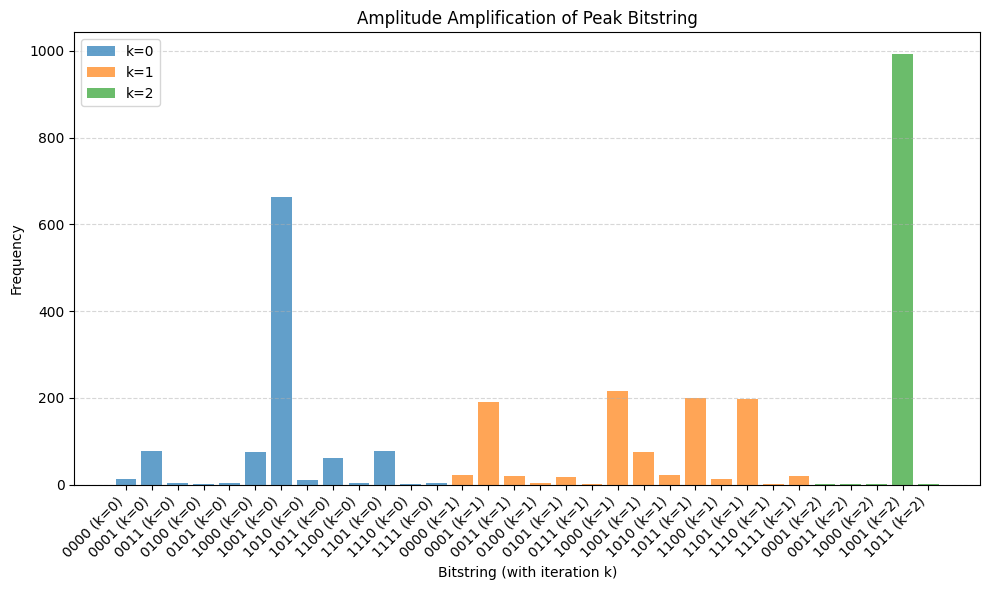

In [44]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# --- Configuration ---
qasm_path = "circuit_qasm/P1_little_peak.qasm"
n_system = 4  # Number of qubits
shots = 1000  # Number of measurements

# Load the QASM circuit
with open(qasm_path, "r") as f:
    qasm_str = f.read()
state_prep = qml.from_qasm(qasm_str)

# Device for initial sampling
dev_sample = qml.device("default.qubit", wires=n_system, shots=shots)

# --- Step 1: Identify the peak bitstring ---
@qml.qnode(dev_sample)
def sample_circuit():
    state_prep(wires=range(n_system))
    return qml.sample()

# Run the circuit and find the most frequent bitstring
samples = sample_circuit()
bitstrings = ["".join(map(str, s)) for s in samples]
peak_bitstring = Counter(bitstrings).most_common(1)[0][0]
print(f"🌟 Identified peak bitstring: {peak_bitstring}")

# --- Step 2: Define the Amplitude Amplification Circuit ---
dev = qml.device("default.qubit", wires=n_system, shots=shots)

# Oracle: Flips the phase of the peak bitstring
def oracle():
    dim = 2 ** n_system
    diag = np.ones(dim, dtype=complex)
    target_index = int(peak_bitstring, 2)
    diag[target_index] = -1  # Phase flip for peak
    qml.DiagonalQubitUnitary(diag, wires=range(n_system))

# Diffusion operator: D = A S_0 A^\dagger
def diffusion():
    qml.adjoint(state_prep)(wires=range(n_system))  # A^\dagger
    # S_0 = 2|0...0><0...0| - I
    dim = 2 ** n_system
    diag_S0 = -np.ones(dim, dtype=complex)
    diag_S0[0] = 1  # 1 for |0...0>, -1 elsewhere
    qml.DiagonalQubitUnitary(diag_S0, wires=range(n_system))
    state_prep(wires=range(n_system))  # A

@qml.qnode(dev)
def amplified_circuit(k):
    # Prepare the initial state
    state_prep(wires=range(n_system))
    # Apply k iterations of Q = -A S_0 A^\dagger O
    for _ in range(k):
        oracle()
        diffusion()
    return qml.counts()

# --- Step 3: Run and Collect Results ---
k_values = [0, 1, 2]  # Number of iterations to try
results = {}
for k in k_values:
    counts = amplified_circuit(k)
    results[k] = counts
    print(f"\nResults for k={k} iterations:")
    for bitstring, count in sorted(counts.items()):
        print(f"{bitstring} → {count} times")

# --- Step 4: Visualize with Matplotlib ---
plt.figure(figsize=(10, 6))
for k in k_values:
    bitstrings, counts = zip(*sorted(results[k].items()))
    plt.bar([f"{b} (k={k})" for b in bitstrings], counts, label=f"k={k}", alpha=0.7)

plt.xlabel("Bitstring (with iteration k)")
plt.ylabel("Frequency")
plt.title("Amplitude Amplification of Peak Bitstring")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()